# Q.1

## 1.1
Co-adaptation and internal covariate shift are two phenomena that can occur during the training of a convolutional neural network (CNN).

Co-adaptation refers to the phenomenon where the weights of different neurons in a CNN become correlated with each other. This can happen when the CNN is trained on a dataset that is not very large, or when the learning rate is too high. When co-adaptation occurs, it can make it difficult for the CNN to learn new features, as the weights of the neurons become locked into specific patterns.

Internal covariate shift refers to the phenomenon where the distribution of the inputs to a CNN changes during training. This can happen when the CNN is trained on a dataset that is not very representative of the data that it will be used to classify or regress on. When internal covariate shift occurs, it can make it difficult for the CNN to learn effectively, as the inputs to the CNN are constantly changing.

There are a number of techniques that can be used to address the problems of co-adaptation and internal covariate shift. One common technique is to use data augmentation, which involves artificially increasing the size of the training dataset by creating new data points from the existing data. This can help to reduce co-adaptation by providing the CNN with more examples of different patterns.

Another common technique is to use batch normalization, which involves normalizing the inputs to each layer of the CNN before they are processed by the layer. This can help to reduce internal covariate shift by ensuring that the inputs to each layer of the CNN are more consistent.

Finally, it is also important to choose a learning rate that is appropriate for the size of the dataset and the complexity of the CNN. A learning rate that is too high can lead to co-adaptation, while a learning rate that is too low can lead to overfitting.

In [7]:
import numpy as np
import pandas as pd
import math
import argparse
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time
import random

In [45]:
! nvidia-smi

Sat Apr  1 19:36:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   48C    P0    57W / 300W |   1271MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Q1.2

In [48]:
def plot_loss_acc(loss, acc, epoch):
    epochs = [i for i in range(1, epoch+1)]
    plt.subplot(1,2,1)
    plt.plot(epochs, loss)
    plt.ylabel('loss')
    plt.title('loss/epoch')
    plt.subplot(1,2,2)
    plt.plot( epochs, acc)
    plt.ylabel('acc')
    plt.title('acc/epoch')

In [49]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.convlayers = nn.Sequential(
                            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(6),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(16),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(120),
                           )
        self.flatten = nn.Flatten()
        self.FullConnected = nn.Sequential(
                                nn.Linear(120, 84),
                                nn.Tanh(),
                                nn.Linear(84, 10),
                                nn.Sigmoid()
                              )
    def forward(self, x):
        x = self.convlayers(x)
        x = self.flatten(x)
        logits = self.FullConnected(x)
        return logits

In [50]:
def train_model(epochs, train_loader, test_loader, model, loss_function, optimizer, device):
    for epoch in range(1, epochs + 1):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0
        for imgs, labels in train_loader:
            X = imgs.to(device)
            y = labels.to(device)
            optimizer.zero_grad()
            
            train_prediction = model(X)
            
            loss = loss_function(train_prediction, y)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            _, predicted = train_prediction.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels.to(device)).sum().item()
            
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_values.append(epoch_train_loss)
        epoch_train_accuracy = 100.0 * correct / total
        train_accuracy_values.append(epoch_train_accuracy)
#         print(f"Total Epoch - {epoch}/{epochs} \nTotal Training Loss- {epoch_train_loss: .3f} \nTotal Training Accuracy -{epoch_train_accuracy: .3f} %")

        model.eval()
        running_test_loss = 0.0
        correct = 0
        total = 0
        for imgs, labels in test_loader:
            X = imgs.to(device)
            y = labels.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)
            running_test_loss += loss.item()
            _, predicted = torch.max(pred.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.to(device)).sum().item()
            
        epoch_test_loss = running_test_loss / len(test_loader)
        test_loss_values.append(epoch_test_loss)
        epoch_test_accuracy = 100.0 * correct / total
        test_accuracy_values.append(epoch_test_accuracy)
#         print(f"Total Epoch - {epoch}/{epochs}\nTotal Test Loss -{epoch_test_loss: .3f} \nTotal Test Accuracy -{epoch_test_accuracy: .3f} %")

In [51]:
epochs = 20
data_path= "./data"
mean = 0
std = 1

model1_withbatch = LeNet().to(device)
optimizer = torch.optim.SGD(model1_withbatch.parameters(), lr=0.1)

criterion = nn.CrossEntropyLoss()

data_transforms = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=mean, std=std)])
training_data = torchvision.datasets.MNIST(data_path, train=True,transform=data_transforms, download=True)
test_data = torchvision.datasets.MNIST(data_path, train=False,transform=data_transforms, download=True)
BATCH_SIZE = 128
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,num_workers=4)

train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
training_time_total = []

train_model(epochs, train_dataloader, test_dataloader, model1_withbatch, criterion, optimizer, device)
print(f"Final Training Accuracy - {train_accuracy_values[-1]: .3f} % \nFinal Test Accuracy - {test_accuracy_values[-1]: .3f} %\n")

Final Training Accuracy -  99.142 % 
Final Test Accuracy -  98.910 %



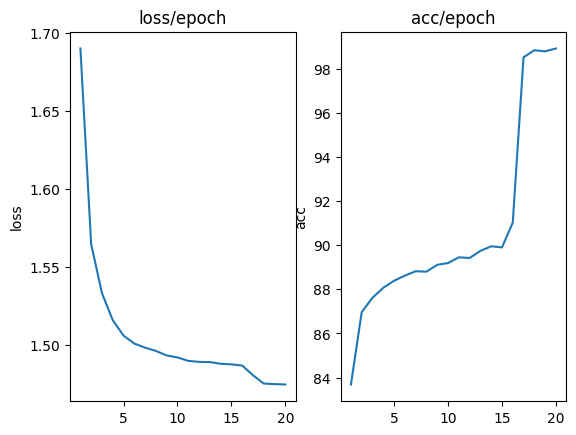

In [52]:
import matplotlib.pyplot as plt
plot_loss_acc(test_loss_values, test_accuracy_values, epochs)

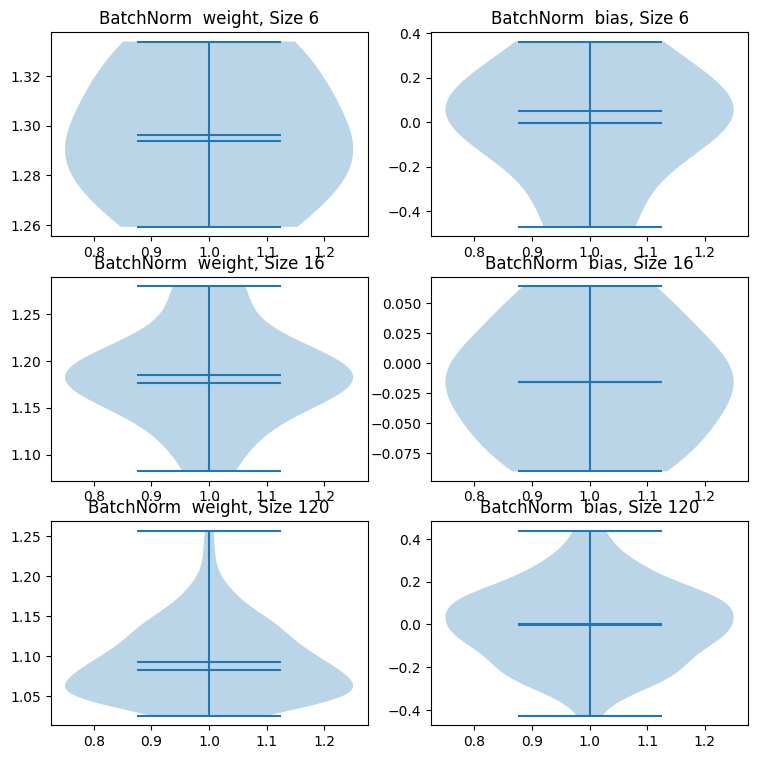

In [53]:
fig, axs = plt.subplots(3,2, figsize=(9,9))
i=0
for a,b in model1_withbatch.named_modules():
    if(isinstance(b, nn.BatchNorm2d)):
        for name, param in b.named_parameters():
            if name in ['weight','bias']:
                axs[int(i/2), int(i%2)].violinplot(param.detach().cpu().numpy(), vert=True, showmeans=True, showmedians=True)
                axs[int(i/2), int(i%2)].set_title(f'BatchNorm  {name}, Size ' + str(param.size(dim=0)))
                
                i+=1

In [54]:
[print(p) for p in model1_withbatch.children()]

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): Tanh()
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (8): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (9): Tanh()
  (10): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Flatten(start_dim=1, end_dim=-1)
Sequential(
  (0): Linear(in_features=120, out_features=84, bias=True)
  (1): Tanh()
  (2): Linear(in_features=84, out_features=10, bias=True)
  (3): Sigmoid()
)


[None, None, None]

## Q1.3

In [55]:
def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)
    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
        default_figsize[0] * n_cols,
        default_figsize[1] * n_rows
        ))
    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax

In [56]:
class LeNet_Batch(nn.Module):
    def __init__(self):
        super(LeNet_Batch, self).__init__()
        self.convlayers = nn.Sequential(
                            nn.BatchNorm2d(1),
                            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(6),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(16),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(120),
                        )
        self.flatten = nn.Flatten()
        self.FullConnected = nn.Sequential(
                                nn.Linear(120, 84),
                                nn.Tanh(),
                                nn.Linear(84, 10),
                                nn.Softmax(1)
                            )
    def forward(self, x):
        x = self.convlayers(x)
        x = self.flatten(x)
        logits = self.FullConnected(x)
        return logits

In [57]:
data_transforms2 = transforms.Compose([transforms.Resize((32,32)),
transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(data_path, train=True,transform=data_transforms2, download=True)
test_data = torchvision.datasets.MNIST(data_path, train=False,transform=data_transforms2, download=True)

train_dataloader = DataLoader(train_data, batch_size=128,shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)
model2 = LeNet_Batch().to(device)
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
training_time_total = []
train_model(epochs, train_dataloader, test_dataloader, model2, criterion, optimizer, device)
print("Training Finished..\n")
print(f"Final Training Accuracy - {train_accuracy_values[-1]: .3f} % \
n Final Test Accuracy - {test_accuracy_values[-1]: .3f} %\n")

Training Finished..

Final Training Accuracy -  99.518 % n Final Test Accuracy -  99.200 %



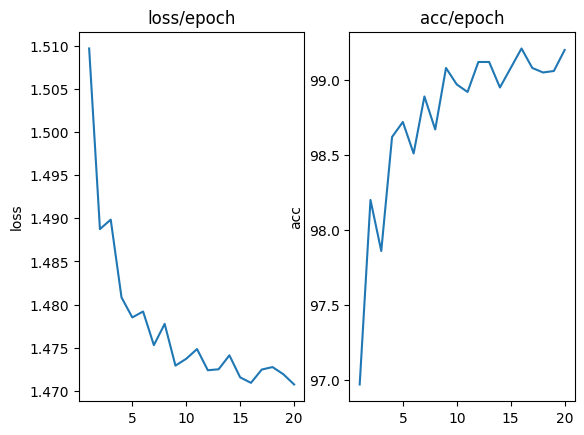

In [58]:
plot_loss_acc(test_loss_values, test_accuracy_values, epochs)

## As we can see from the graph in part(3), the model converges quicker and trains faster as compared to part(2). By normalizing the data, the loss and accurary saturates quicker, as it scales and shifts the data, and making the network more stable. Also, the overall accuracy is higher in part(3)

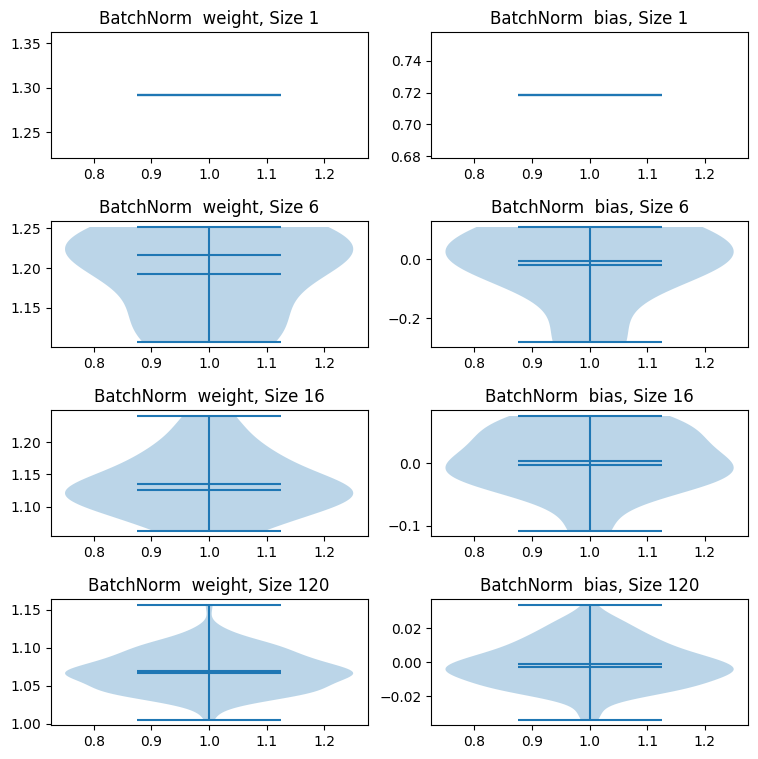

In [59]:
fig, axs = plt.subplots(4,2, figsize=(9,9))
i=0
fig.subplots_adjust(hspace=.5)

for a,b in model2.named_modules():
    if(isinstance(b, nn.BatchNorm2d)):
        for name, param in b.named_parameters():
            if name in ['weight','bias']:
                axs[int(i/2), int(i%2)].violinplot(param.detach().cpu().numpy(), vert=True, showmeans=True, showmedians=True)
                axs[int(i/2), int(i%2)].set_title(f'BatchNorm  {name}, Size ' + str(param.size(dim=0)))
                i+=1

## Q1.4

In [60]:
class LeNet_Dropout(nn.Module):
    def __init__(self):
        super(LeNet_Dropout, self).__init__()
        self.convlayers = nn.Sequential(
                            nn.Dropout(p=0.2),
                            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.Dropout(p=0.5),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.Dropout(p=0.5),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.Dropout(p=0.5),
                            )
        self.flatten = nn.Flatten()
        self.FullConnected = nn.Sequential(
                                nn.Linear(120, 84),
                                nn.Tanh(),
                                nn.Linear(84, 10),
                                nn.Softmax(1)
                                )
    def forward(self, x):
        x = self.convlayers(x)
        x = self.flatten(x)
        logits = self.FullConnected(x)
        return logits

In [61]:
data_transform3 = transforms.Compose([
                                transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std)])
train_data = torchvision.datasets.MNIST(data_path, train=True, transform=data_transform3, download=True)
test_data = torchvision.datasets.MNIST(data_path, train=False, transform=data_transform3, download=True)

train_dataloader = DataLoader(train_data, batch_size=128, shuffle= True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)
model3 = LeNet_Dropout().to(device)
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
training_time_total = []
train_model(epochs, train_dataloader, test_dataloader, model3, criterion, optimizer, device)
print("Training Finished..\n")
print(f"Final Training Accuracy - {train_accuracy_values[-1]: .3f} % \
n Final Test Accuracy - {test_accuracy_values[-1]: .3f} %\n")

Training Finished..

Final Training Accuracy -  94.435 % n Final Test Accuracy -  97.040 %



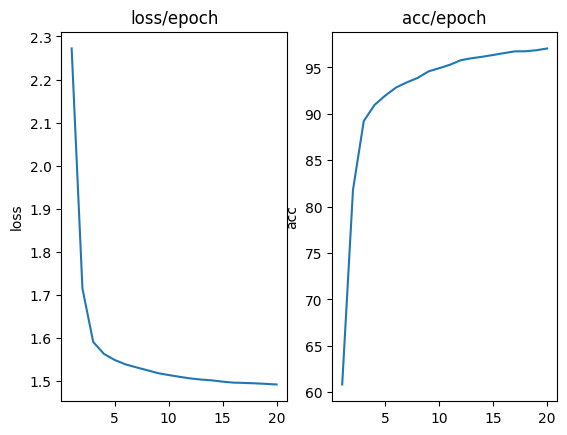

In [62]:
plot_loss_acc(test_loss_values, test_accuracy_values, epochs)

## We see that in part(4) with dropout, the train and test accuracies are lower that part(2) and part(3). That's because initially the model is not overtraining and keeping it generatlized

## Q1.5

In [63]:
class LeNet_DropNorm(nn.Module):
    def __init__(self):
        super(LeNet_DropNorm, self).__init__()
        self.convlayers = nn.Sequential(
                            nn.BatchNorm2d(1),
                            nn.Dropout(p=0.2),
                            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(6),
                            nn.Dropout(p=0.5),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(16),
                            nn.Dropout(p=0.5),
                            nn.AvgPool2d(kernel_size=2),
                            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,
                            stride=1),
                            nn.Tanh(),
                            nn.BatchNorm2d(120),
                            nn.Dropout(p=0.5),
                            )
        self.flatten = nn.Flatten()
        self.FullConnected = nn.Sequential(
                            nn.Linear(120, 84),
                            nn.Tanh(),
                            nn.Linear(84, 10),
                            nn.Softmax(1)
                            )
    def forward(self, x):
        x = self.convlayers(x)
        x = self.flatten(x)
        logits = self.FullConnected(x)
        return logits

In [64]:
data_transform = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
train_data = torchvision.datasets.MNIST(data_path, train=True, transform=data_transform, download=True)
test_data = torchvision.datasets.MNIST(data_path, train=False, transform=data_transform, download=True)
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)
model4 = LeNet_DropNorm().to(device)
optimizer = torch.optim.SGD(model4.parameters(), lr=0.1)
train_loss_values = []
test_loss_values = []
train_accuracy_values = []
test_accuracy_values = []
train_model(epochs, train_dataloader, test_dataloader, model4, criterion, optimizer, device)
print("Training Finished..\n")
print(f"Final Training Accuracy - {train_accuracy_values[-1]: .3f} % \
n Final Test Accuracy - {test_accuracy_values[-1]: .3f} %\n")

Training Finished..

Final Training Accuracy -  96.898 % n Final Test Accuracy -  98.540 %



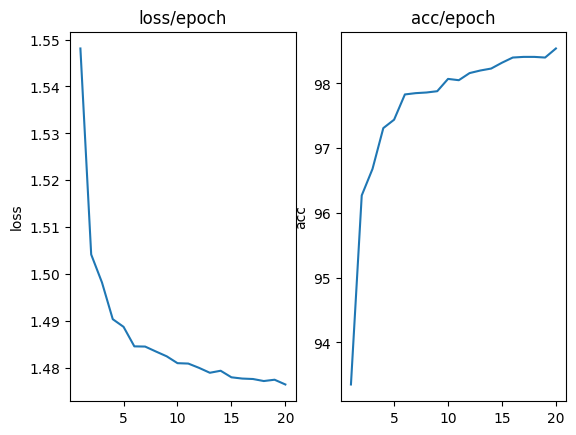

In [65]:
plot_loss_acc(test_loss_values, test_accuracy_values, epochs)

## as we compare (4) and (5) graph, we see that the model with both BatchNorm and Dropout (5) performs better on test loss and accuracy, as compared to model (4). We see that the graph saturates properly in part (5), because dropout, makes the model less susceptible to overfitting, and that's why the test accuracry is much better

# Q.2

## Q2.1

In [1]:
from models import MiniGoogLeNet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from matplotlib import rcParamsDefault
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow import keras
from keras import utils as np_utils
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model

In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print('\n ----- \n')
print(f"Number of training records: {len(train_images)}")
print(f"Number of test records: {len(test_images)}")
print(f"Total number of records: {len(train_images) + len(test_images)}")


 ----- 

Number of training records: 60000
Number of test records: 10000
Total number of records: 70000


In [3]:
train_labels_pd_series = pd.Series(train_labels)
print(f"Number of unique classes: {train_labels_pd_series.nunique()}")
print('Number of images per class in the training dataset:')
train_labels_pd_series.value_counts()

Number of unique classes: 10
Number of images per class in the training dataset:


9    6000
0    6000
3    6000
2    6000
7    6000
5    6000
1    6000
6    6000
4    6000
8    6000
dtype: int64

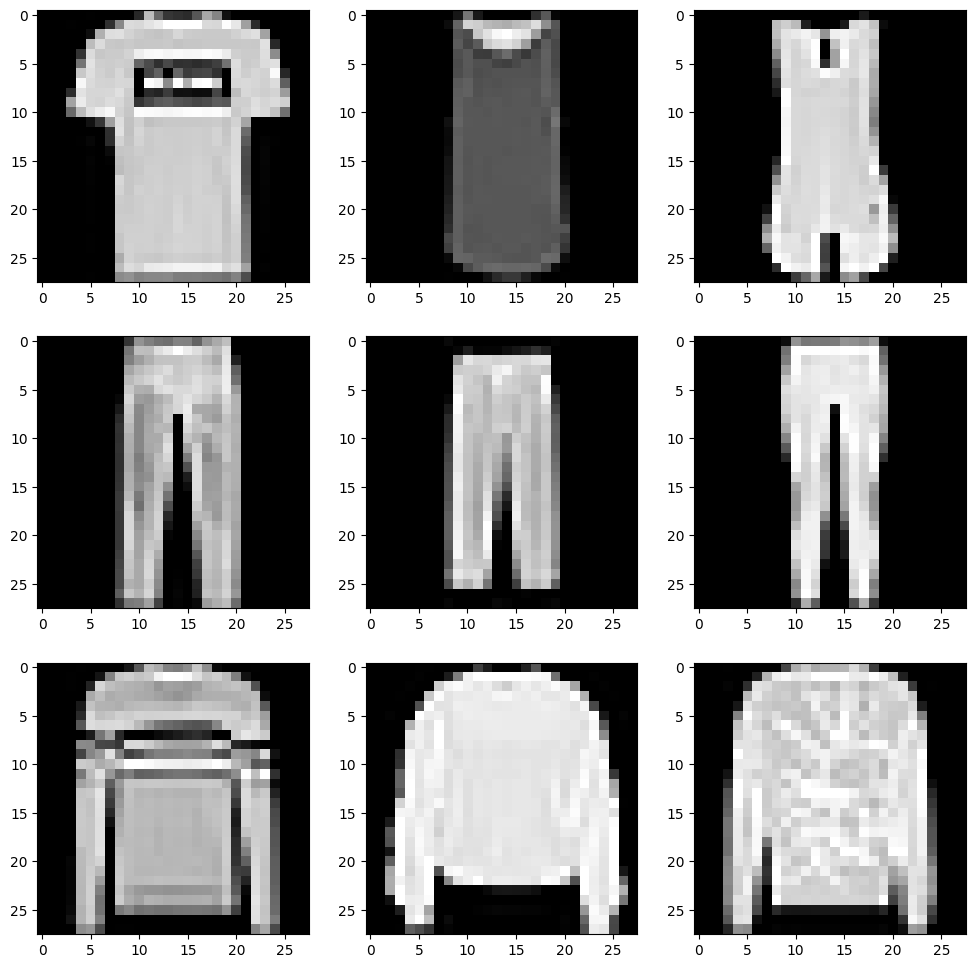

In [4]:
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i in range(3):
    subset_imgs = train_images[train_labels == i, :, :]
    for j in range(3):
        ax[i, j].imshow(subset_imgs[j, :, :], cmap='gray')

In [3]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


train_images = train_images.reshape(-1, 28, 28, 1)
test_images = test_images.reshape(-1, 28, 28, 1)

train_images = tf.pad(train_images, [[0,0],[2,2], [2,2], [0,0]])
test_images = tf.pad(test_images, [[0,0],[2,2], [2,2], [0,0]])


In [6]:
train_loss = []
learn_rate = []
for i in tqdm(range(-9, 2)):
    lr = 10**i
    model = MiniGoogLeNet(32,32,1,10)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.SGD(learning_rate=lr),metrics=['accuracy'])
    _ = model.fit(x=train_images,y=train_labels,batch_size=64,epochs=5,validation_data = (test_images, test_labels),verbose=0)
    train_loss.append(model.history.history['loss'][-1])
    learn_rate.append(lr)

100%|██████████| 11/11 [17:15<00:00, 94.11s/it]


[Text(0, 0.5, 'Training Loss'),
 Text(0.5, 0, 'Learning Rate'),
 None,
 Text(0.5, 1.0, 'Training Loss v. Learning Rate')]

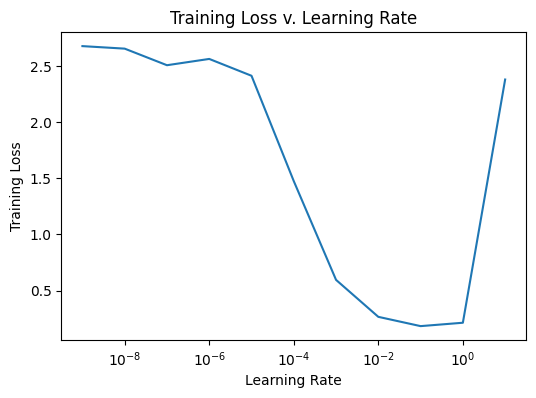

In [7]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(learn_rate, train_loss)
ax.set(ylabel='Training Loss',xlabel='Learning Rate',xscale='log',title='Training Loss v. Learning Rate')

In [8]:
print(learn_rate[np.argmin(train_loss)], learn_rate[np.argmax(train_loss[1:])])

0.1 1e-09


## Q2.2

In [9]:
lr_max = 0.1
lr_min = 1e-7

from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

In [10]:
class CyclicLR(Callback):
    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000.,mode='triangular',gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
            
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}
        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        self.history.setdefault('lr',[]).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations',[]).append(self.trn_iterations)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        K.set_value(self.model.optimizer.lr, self.clr())
        

In [11]:
clr = CyclicLR(base_lr=lr_min,max_lr=lr_max,step_size=10**3,mode='exp_range',gamma=0.99994)
model = MiniGoogLeNet(32,32,1,10)
# model.summary()

Model: "minigooglenet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_209 (Conv2D)            (None, 32, 32, 96)   960         ['input_12[0][0]']               
                                                                                                  
 batch_normalization_209 (Batch  (None, 32, 32, 96)  384         ['conv2d_209[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_220 (Activation)    (None, 32, 32, 96)   0           ['batch_normalization

In [12]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer='sgd',metrics=['accuracy'])
history = model.fit(x=train_images,y=train_labels,batch_size=64,epochs=5,validation_data = (test_images, test_labels),verbose=1,callbacks=[clr])

Epoch 1/5
938/938 [==============================] - 21s 21ms/step - loss: 0.7482 - accuracy: 0.7376 - val_loss: 2.2506 - val_accuracy: 0.5863
Epoch 2/5
938/938 [==============================] - 19s 20ms/step - loss: 0.2959 - accuracy: 0.8943 - val_loss: 0.2540 - val_accuracy: 0.9070
Epoch 3/5
938/938 [==============================] - 19s 20ms/step - loss: 0.2338 - accuracy: 0.9174 - val_loss: 0.5333 - val_accuracy: 0.8239
Epoch 4/5
938/938 [==============================] - 19s 20ms/step - loss: 0.2320 - accuracy: 0.9179 - val_loss: 0.2127 - val_accuracy: 0.9236
Epoch 5/5
938/938 [==============================] - 19s 20ms/step - loss: 0.1774 - accuracy: 0.9380 - val_loss: 0.3059 - val_accuracy: 0.8953


In [13]:
df_metrics = pd.DataFrame(data={
            'epoch': [i for i in range(1, 6)] * 4,
            'metric': ['accuracy'] * 5 + ['loss'] * 5 + ['val_accuracy'] * 5 + ['val_loss'] * 5,
            'value': history.history['accuracy'] + history.history['loss'] + history.history['val_accuracy'] + history.history['val_loss']
            })
df_metrics.head()

,epoch,metric,value
0,1,accuracy,0.737583
1,2,accuracy,0.894317
2,3,accuracy,0.917383
3,4,accuracy,0.917950
4,5,accuracy,0.938033


In [14]:
acc = df_metrics[df_metrics['metric'] == 'accuracy']
loss = df_metrics[df_metrics['metric'] == 'loss']
val_acc = df_metrics[df_metrics['metric'] == 'val_accuracy']
val_loss = df_metrics[df_metrics['metric'] == 'val_loss']

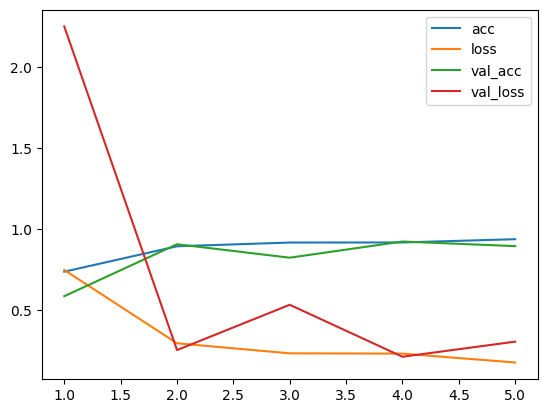

In [15]:
plt.plot(acc['epoch'], acc['value'], label='acc')
plt.plot(loss['epoch'], loss['value'], label='loss')
plt.plot(val_acc['epoch'], val_acc['value'], label='val_acc')
plt.plot(val_loss['epoch'], val_loss['value'], label='val_loss')
plt.legend()


## Q2.3
### Find the training loss for different batch sizes. Also I have implemented mini-batches for large batches which would exceed the GPU memory contraints

In [43]:
import math

epochs = 5
batch_sizes = [int(math.pow(2, 5+i)) for i in range(10)]
loss_fn = tf.keras.losses.categorical_crossentropy
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

loss_values = {}
for batch_size in batch_sizes:
    print('-- Batch size --  %d' %(batch_size,))
    # Prepare the training dataset.
    model = MiniGoogLeNet(32,32,1,10)
    effective_batch_size = batch_size
    
    loss_values[batch_size] = {}
    
    if(batch_size >= 2048):
        effective_batch_size = 2048
        
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(effective_batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
    val_dataset = val_dataset.batch(effective_batch_size)
    
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))
        gradients = []
        running_loss = []
        loss_values[batch_size][epoch] = []
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            with tf.GradientTape() as tape:

                logits = model(x_batch_train, training=True)  # Logits for this minibatch

                # Compute the loss value for this minibatch.
                loss_value = loss_fn(y_batch_train, logits)

            grads = tape.gradient(loss_value, model.trainable_weights)
        
            if(batch_size >= 2048):
                if(((step+1)*effective_batch_size) % batch_size == 0):
                    for g in gradients:
                        optimizer.apply_gradients(g)
                    loss_values[batch_size][epoch].append(np.average(running_loss))
                else:
                    gradients.append(zip(grads, model.trainable_weights))
                    running_loss.append(loss_value)
            else:
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                loss_values[batch_size][epoch].append(np.average(loss_value.numpy()))
            # Log every 60 batches.
#             if step % 60 == 0:
#                 print("Training loss (for one batch) at step %d: %.4f"% (step))
#                 print("Seen so far: %d samples" % ((step + 1) * effective_batch_size))
    


-- Batch size --  32

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  64

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  128

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  256

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  512

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  1024

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  2048

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  4096

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4
-- Batch size --  8192

Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start o

Text(0.5, 1.0, 'Training loss / Epoch, For given batch_size ')

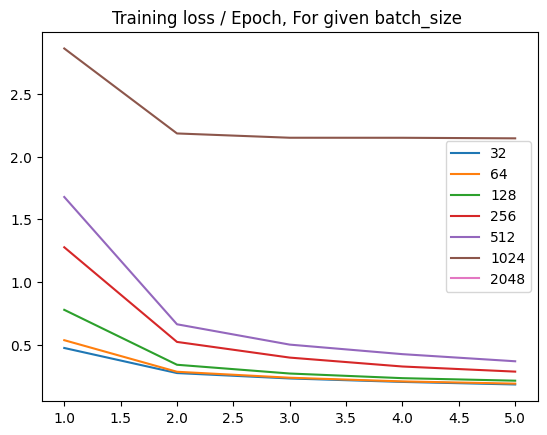

In [53]:
for b in batch_sizes[:-3]:
    losses = []
    for i in range(5):
        loss = np.average(np.array(loss_values[b][i]))
        losses.append(loss)
    plt.plot(range(1,6), losses, label=str(b))
plt.legend()
plt.title('Training loss / Epoch, For given batch_size ')

## For larger batch sizes, we see that the training loss is higher, that is because the model performs less backpropagations and gradients are applied less often as compared to small batch sizes

# Q3
## 3.1

Ans: 
Alexnet

W_O = Size (width) of output image.
W_I = Size (width) of input image.
K = Size (width) of kernels used in the Conv Layer.
N = Number of kernels.
S = Stride of the convolution operation.
P = Padding.

Size (width) of single layer convolution output
C_O = (W_I - K + 2P)/S + 1

Size (width) of single Maxpool layer,
M_O = (I- POOL_SIZE)/S +1

For conv layer and fully connected layer,
W_c = Number of weights of the Conv Layer.
B_c = Number of biases of the Conv Layer.
P_c = Number of parameters of the Conv Layer.
N = Number of kernels.
C = Image Channels

W_c = K^2 x C x N
B_c = N
P_c = W_c + B_c

Input = (227 - 11)/4 + 1 = 55
Conv1 = 11^2 x 3 x 96 + 96 = 34,944 
Output = (55-3)/2 + 1 = 27
MaxPool1 = 0 params, Output size = 27 x 27 x 96
Output = (27 - 5 + 2(2))/1 + 1 = 27
Conv2 = 5^2 x 96 x 256 + 256= 614,656
Output = (27 - 3)/2 + 1 = 13
MaxPool2 = 0 params, Output size = 13 x 13 x 256
Output = (13 - 3 + 2)/1 + 1 = 13
Conv3 = 3^2 x 256 x 384 + 385 = 885,120
Output = (13 - 3 + 2)/1 + 1 = 13
Conv4 = 3^2 x 384 x 384 + 384 = 1,327,488
Output = (13 - 3 + 2)/1 + 1 = 13
Conv5 = 3^2 x 384 x 256 + 256 = 884992
Output = (13 - 3)/2 + 1  = 6
MaxPool5 = 0 params,  Outputsize = 6 x 6 x 256
FC1 = 9216 x 4096 + 4096 = 37,752,832
FC2 = 4096 x 4096 + 4096 = 16,781,312
FC3 = 4096 x 1000 + 1000 = 40,970,000

Summing up all the parameters, we get
Total Parameters = 62,378,344 

## Q3.2

Layer         |    Number of Activations (Memory)   |       Parameters (Compute)
Input                   224*224*3=150K                          0
CONV3-64                224*224*64=3.2M                     (3*3*3)*64 = 1,728
CONV3-64                224*224*64=3.2M                     (3*3*64)*64 = 36,864
POOL2                   112*112*64=800K                         0
CONV3-128               112*112*128=1.6M                    (3*3*64)*128 = 73,728
CONV3-128               112*112*128=1.6M                    (3*3*128)*128 = 147,456
POOL2                   56*56*128=400K                          0
CONV3-256               56*56*256=800K                      (3*3*128)*256 = 294,912
CONV3-256               56*56*256=800K                      (3*3*256)*256 = 589,824
CONV3-256               56*56*256=800K                      (3*3*256)*256 = 589,824
CONV3-256               56*56*256=800K                      (3*3*256)*256 = 589,824
POOL2                   28*28*256=200K                          0
CONV3-512               28*28*512=400K                      (3*3*256)*512 = 1,179,648
CONV3-512               28*28*512=400K                      (3*3*512)*512 = 2,359,296
CONV3-512               28*28*512=400K                      (3*3*512)*512 = 2,359,296
CONV3-512               28*28*512=400K                      (3*3*512)*512 = 2,359,296
POOL2                   14*14*512=100K                          0
CONV3-512               14*14*512=100K                      (3*3*512)*512 = 2,359,296
CONV3-512               14*14*512=100K                      (3*3*512)*512 = 2,359,296
CONV3-512               14*14*512=100K                      (3*3*512)*512 = 2,359,296
CONV3-512               14*14*512=100K                      (3*3*512)*512 = 2,359,296
POOL2                   7*7*512=25K                             0
FC 1                    1*1*4096=4K                         (7*7*512)*4096 = 102,760,448
FC 2                    1*1*4096=4K                         4096*4096 = 16,777,216
FC 3                    1*1*1000=1K                         4096*1000 = 4,096,000


Total                   16.3M                               144M Parameters (approx)

## Q3.3

The receptive field of a convolutional layer is the region in the input image that impacts a particular feature map. The calculation of the receptive field of a stack of N convolution layers, each having a filter size of F × F, can be determined through a simple mathematical formula. Assuming the receptive field of the first convolution layer is F × F, the receptive field of the second convolution layer would be (F + (F − 1)) × (F + (F − 1)) = 2F − 1. Similarly, the third convolution layer would have a receptive field of (2F − 1 + (F − 1)) × (2F − 1 + (F − 1)) = 3F − 2. By following this pattern, the receptive field of the Nth convolution layer can be calculated as NF − N + 1. For instance, with 3 filters of size 5 × 5, the receptive field would be 13 × 13.

## Q3.4

a. The Inception module in a convolutional neural network is designed with the primary goal of creating a highly efficient and robust architecture that can effectively capture both local and global features present in the input data. This is accomplished by incorporating multiple parallel convolutional filters of different sizes along with a pooling operation, which are then merged together. The underlying motivation for this unique design is to enable the network to learn a wide variety of features at different scales and spatial resolutions while requiring fewer parameters, thereby leading to superior performance. By seamlessly integrating the results of these parallel operations, the Inception module can effectively capture both fine-grained and coarse features in the input, resulting in a significant enhancement in overall performance.

b. To ensure that the output sizes of the convolutions in both the Inception modules are 32x32, careful selection of padding values is required for each convolution and max-pooling layer. For the Naive Version, the resulting output size is 32x32x672, achieved by combining the outputs of the convolutions with filter sizes of 128, 192, 96, and 256. On the other hand, the Inception module with dimension reductions yields an output size of 32x32x480 by utilizing convolutions with filter sizes of 128, 192, 96, and 64.

c. For naive Inception module -
[1x1 conv, 128] 32 × 32 × 256 × 1 × 1 × 128 = 33,554,432
[3x3 conv, 192] 32 × 32 × 256 × 3 × 3 × 192 = 452,984,832
[5x5 conv, 96] 32 × 32 × 256 × 5 × 5 × 96 = 629,145,600

Total operations = 1,115,684,864


For Inception module with dimension reductions -
[1x1 conv, 128] 32 × 32 × 256 × 1 × 1 × 128 = 33,554,432
[1x1 conv, 128] 32 × 32 × 256 × 1 × 1 × 128 = 33, 554,432
[1x1 conv, 32]  32 × 32 × 256 × 1 × 1 × 32 = 8,388,608
[3x3 conv, 192] 32 × 32 × 128 × 3 × 3 × 192 = 226,492,416
[5x5 conv, 96]  32 × 32 × 32 × 5 × 5 × 96 = 78,643,200
[1x1 conv, 64]  32 × 32 × 256 × 1 × 1 × 64 = 16,777,216

Total operations = 397,410,304

d. The 1x1 convolutions reduce depth keeping the same spatial dimensions.
This allows for fewer computations.

Computations saved by using the Inception module with dimension reductions - 
1,115,684,864 - 397,410,304 = 718,274,560